In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs 


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from skimage.measure import block_reduce
import time
from IPython import display
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import glob
import imageio

In [ ]:
image_sizes = {"cryptopunks": (32, 32)}
batch_size = 75

In [ ]:
import tensorflow as tf

def get_data(collection):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        collection,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_sizes["cryptopunks"],
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        collection,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_sizes["cryptopunks"],
        batch_size=batch_size,
    )
    return train_ds, val_ds

train_ds, val_ds = get_data("/content/gdrive/MyDrive/cryptopunks")

def process(image,label):
    image = tf.cast((image - 127.5)/127.5 ,tf.float32)
    return image,label

train_ds = train_ds.map(process)

print(train_ds)

# train_ds



Found 10561 files belonging to 2 classes.
Using 8449 files for training.
Found 10561 files belonging to 2 classes.
Using 2112 files for validation.
<MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
for image, label in train_ds.take(1):  # only take first element of dataset
    print(image)

In [ ]:
for image, label in train_ds.take(1):  # only take first element of dataset
    print(image)

tf.Tensor(
[[[[-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   ...
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]]

  [[-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   ...
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]]

  [[-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   ...
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]]

  ...

  [[-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   ...
   [-0.22352941  0.04313726  0.1764706 ]
   [-0.22352941  0.04313726  0.1764706 ]
   [-

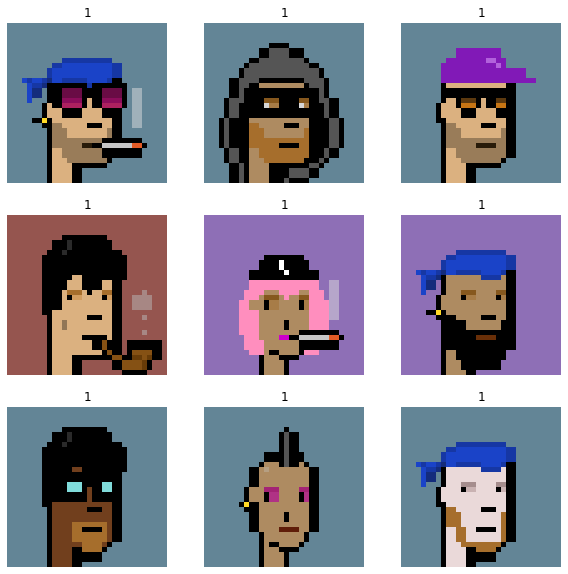

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow((127.5 + 127.5*images[i].numpy()).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

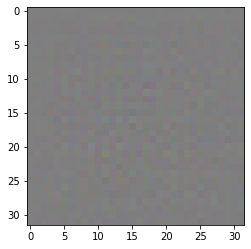

In [9]:
# Creating model
generator = make_generator_model()

# Length 100 noise vector
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

%matplotlib inline
plt.imshow((127.5 + 127.5*generated_image[0, :, :, :].numpy()).astype("uint8"), cmap='viridis')

In [10]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

decision = discriminator(generated_image)

print (decision)

tf.Tensor([[0.00163696]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim]) 

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, labels in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [63]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        # plt.subplot(4, 4, i+1)
        plt.imshow((127.5+predictions[i, :, :, :]*127.5).numpy().astype("uint8"), cmap='viridis')
        plt.axis('off')
        plt.savefig('/content/epoch_images/image_at_epoch_{:04d}.png'.format(i))
        plt.show()

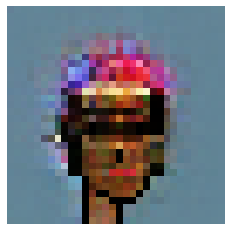

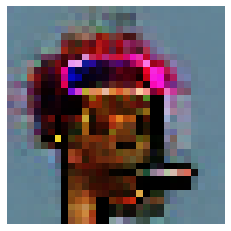

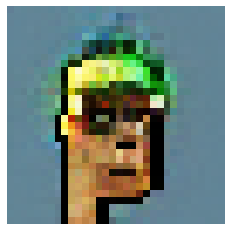

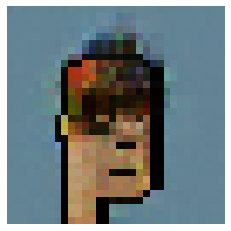

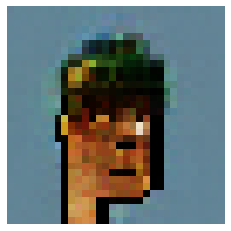

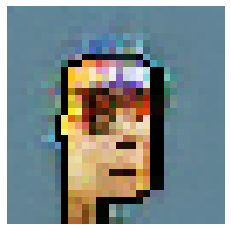

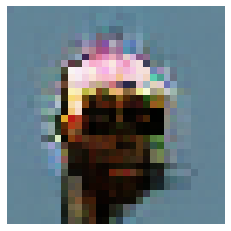

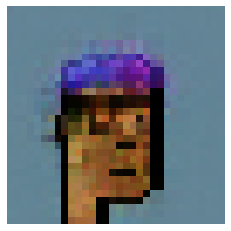

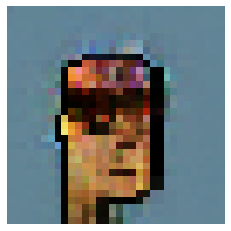

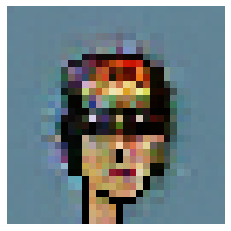

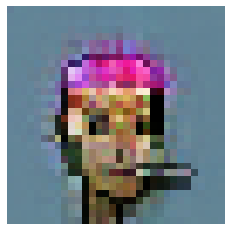

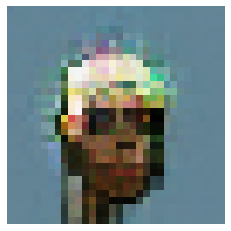

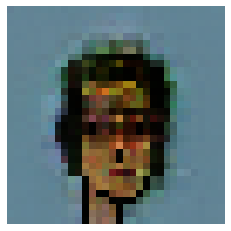

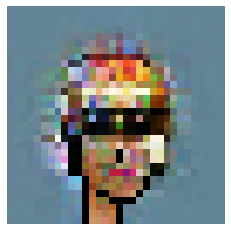

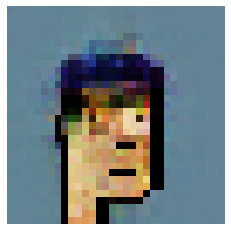

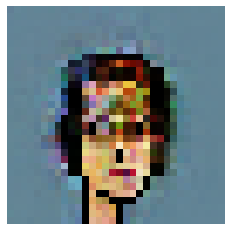

In [64]:
num_epochs = 1
train(train_ds, num_epochs)

